In [ ]:
#all_slow
#all_cuda

# Examples of many applications

This notebook is a quick(ish) test of most of the main application people use, taken from `fastbook`.

In [ ]:
#hide
from fastai.vision.all import *
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.collab import *

## Image single classification

In [ ]:
set_seed(99, True)
path = untar_data(URLs.PETS)/'images'
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2,
    label_func=lambda x: x[0].isupper(), item_tfms=Resize(224))

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.166802,0.026535,0.009472,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.046429,0.012175,0.004060,00:15


Should be around 0.01 or less.

In [ ]:
img = PILImage.create('../images/cat.jpg')
print(f"Probability it's a cat: {learn.predict(img)[2][1].item():.6f}")

Probability it's a cat: 1.000000


## Segmentation

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)

In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.969643,2.448999,00:03


epoch,train_loss,valid_loss,time
0,1.696013,1.509799,00:02
1,1.484652,1.214625,00:02
2,1.457932,1.400337,00:02
3,1.351992,1.104257,00:02
4,1.233100,0.925221,00:03
5,1.122062,0.854342,00:02
6,1.028064,0.832836,00:02
7,0.954791,0.818452,00:02


Should be a bit above 0.8.

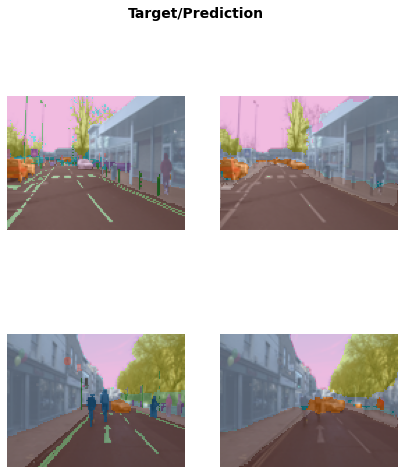

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

RHS pics should be similar to LHS pics.

## Text classification

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
imdb_clas = DataBlock(blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
                      get_x=ColReader('text'), get_y=ColReader('label'), splitter=ColSplitter())
dls = imdb_clas.dataloaders(df, bs=64)

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.634987,0.621853,0.705000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.435843,0.508709,0.805000,00:05
1,0.386479,0.446490,0.790000,00:05
2,0.320961,0.522036,0.770000,00:05
3,0.267238,0.572048,0.785000,00:05


Should be a bit under 0.8.

In [ ]:
learn.predict("I really liked that movie!")

('positive', tensor(1), tensor([1.3686e-05, 9.9999e-01]))

Should be a bit very nearly 1.

## Tabular

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.365791,0.362030,0.824171,00:07
1,0.349386,0.356809,0.832310,00:07
2,0.340156,0.352458,0.831695,00:07


Should be around 0.83

## Collab filtering

In [ ]:
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))

In [ ]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,time
0,1.519063,1.388863,00:00


epoch,train_loss,valid_loss,time
0,1.353412,1.301542,00:00
1,1.173434,0.995304,00:00
2,0.894901,0.777776,00:00
3,0.735333,0.725698,00:00
4,0.670091,0.714968,00:00
5,0.648496,0.713515,00:00


Should be a bit over 0.7

In [ ]:
learn.show_results(max_n=4)

,userId,movieId,rating,rating_pred
0,45.0,95.0,1.0,3.216705
1,6.0,42.0,3.5,3.474894
2,2.0,3.0,4.5,3.789701
3,15.0,34.0,2.5,3.857912


## Keypoints

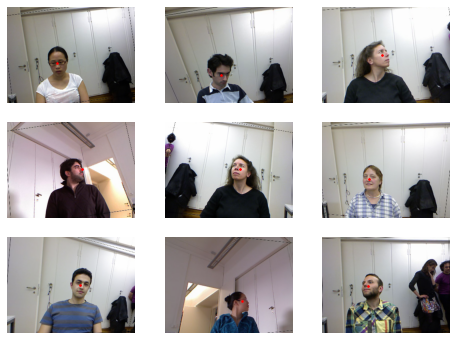

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)])

dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=9.12010818865383e-07)

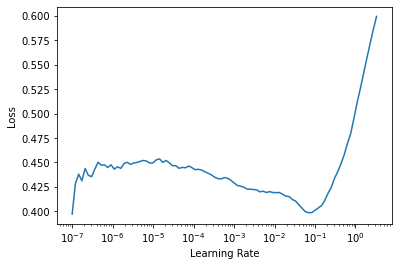

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.048685,0.011717,00:37


epoch,train_loss,valid_loss,time
0,0.003574,0.000477,00:47


Should be around 0.0005

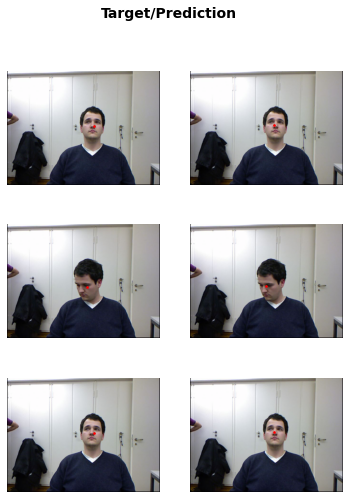

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

Red dots should be close to noses.

## fin -